### 练习4--使用BP算法训练一个神经网络
数据仍然是5000张20X20的灰度图像

In [11]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
data = loadmat('ex4data1.mat')

In [12]:
X = data['X']
y = data['y']

对y进行one-hot编码，y的取值有K类，这里是10类，也即分为$Y_{m\times K}$, $Y[:,0]$表示了对第0类也即数字0的样本标记，也即取值为0的样本其标记值为1否则为0

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(y)
X.shape, Y.shape

((5000, 400), (5000, 10))

In [14]:
Y[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

### 神经网络的构建
1. 决定神经网络的结构--输入为400维向量，输出为10维的向量，假定设置一个含25个节点的隐含层，结构即为(400+1)x(25+1)x10
2. 随机初始化$\Theta$参数矩阵
3. 实现前向传播算法，计算出$h_\Theta$
4. 实现代价函数$J_{(\Theta)}$
5. 利用BP算法，计算梯度
6. 梯度检测
7. 优化$J_{(\Theta)}$

In [17]:
# sigmoid函数
def sigmoid(z):
    return 1/(1+np.exp(-z))
# 定义数字特征
m = X.shape[0] # 5000, 5000个样本
n = X.shape[1] # 400, 400个特征
K = Y.shape[1] # 10, 10个类
# 前向传播 h(x)的计算
def forwardPropagation(theta1, theta2, X):
    a1 = np.insert(X, 0, 1, axis=1) # a1(5000,401)
    z2 = a1*theta1.T # theta1(25,401)
    a2 = np.insert(sigmoid(z2), 0, 1, axis=1) # a2(5000,26)
    z3 = a2*theta2.T # theta2(10, 26) z3(5000, 10)
    h = sigmoid(z3)
    return a1, z2, a2, z3, h
m, n, K

(5000, 400, 10)

#### 代价函数
$$
      J_\Theta=-\frac{1}{m}\sum^m_{i=1}\sum^K_{k=1}\left[y^{(i)}_k\ln(h_\Theta(x^{(i)})_k)+(1-y^{(i)}_k)\ln(1-h_\Theta(x^{(i)})_k)\right]\\+\frac{\lambda}{2m}\sum^{L-1}_{l=1}\sum^{S_{l+1}}_{i=1}\sum^{S_l}_{j=1}(\Theta^{(l)}_{ij})^2
$$

In [32]:
# 定义隐含层大小
hidden_size = 25
# 构造costFunc
def costFunc(Theta, X, Y, _lambda):
    # Theta是一个包含所有参数的向量
    theta1 = np.matrix(np.reshape(Theta[:hidden_size*(n+1)], (hidden_size, n+1)))
    theta2 = np.matrix(np.reshape(Theta[hidden_size*(n+1):], (K, hidden_size+1)))
    a1, z2, a2, z3, h = forwardPropagation(theta1, theta2, X)
    temp = (-1/m)*(Y.T*np.log(h)+(1-Y.T)*np.log(1-h))
    normal = 0
    for i in range(K):
        normal = normal + temp[i, i]
    t1 = np.power(theta1, 2)[:,1:]
    t2 = np.power(theta2, 2)[:,1:]
    reg = (_lambda/(2*m))*(np.sum(t1)+np.sum(t2))
    return normal+reg

In [34]:
# 随机初始化一个Theta
X = np.matrix(X)
Y = np.matrix(Y)
Theta = np.random.random(size=hidden_size*(n+1)+K*(hidden_size+1))
Theta = (Theta-0.5)*0.2 # -0.1~0.1 关键一步
costFunc(Theta, X, Y, _lambda=1), Theta.shape, type(Theta)

(7.17237476312293, (10285,), numpy.ndarray)

#### Back Propagation
反向传播
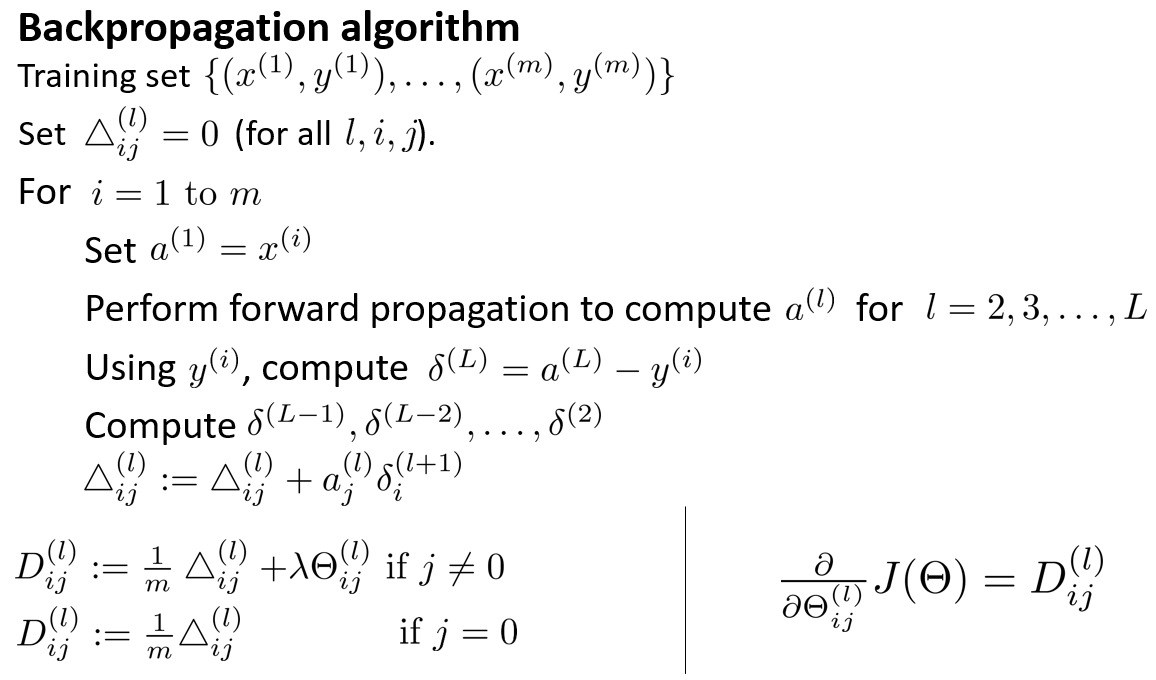


In [40]:
# multiply按元素相乘
def backPropagate(Theta, X, Y, _lambda):
    theta1 = np.matrix(np.reshape(Theta[:hidden_size*(n+1)], (hidden_size, n+1)))
    theta2 = np.matrix(np.reshape(Theta[hidden_size*(n+1):], (K, hidden_size+1)))
    a1, z2, a2, z3, hx = forwardPropagation(theta1, theta2, X)
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    for i in range(m):
        a1i = a1[i,:] # (1, 401)
        z2i = z2[i,:] # (1, 25)
        a2i = a2[i,:] # (1, 26)
        z3i = z3[i,:] # (1, 10)
        hxi = hx[i,:] # (1, 10)
        yi = Y[i,:]   # (1, 10)
        # theta2 (10, 26)
        d3i = hxi-yi # (1, 10)
        d2i = np.multiply(d3i*theta2, a2i)
        d2i = np.multiply(d2i, 1-a2i) # (1, 26)
        # 关键更新
        delta1 = delta1 + d2i[:,1:].T*a1i # 25x401
        delta2 = delta2 + d3i.T*a2i # 10x26
    delta1 = delta1/m
    delta2 = delta2/m
    # 正则化项
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * _lambda) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * _lambda) / m
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    return grad  

In [41]:
grad0 = backPropagate(Theta, X, Y, _lambda=1)
grad0.shape

(10285,)

我们终于准备好训练我们的网络，并用它进行预测。

In [42]:
from scipy.optimize import minimize
fmin = minimize(fun=costFunc, 
               x0=Theta, 
               args=(X, Y, 1), 
               method='TNC', 
               jac=backPropagate, 
               options={'maxiter': 250}
              )
fmin

C:\Users\mrrai\AppData\Local\Temp\ipykernel_3968\654420602.py:2: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  fmin = minimize(fun=costFunc,
C:\Users\mrrai\AppData\Local\Temp\ipykernel_3968\732528124.py:9: RuntimeWarning: divide by zero encountered in log
  temp = (-1/m)*(Y.T*np.log(h)+(1-Y.T)*np.log(1-h))


     fun: 0.4050089079703439
     jac: array([-1.08543297e-03, -7.86118788e-06, -8.21218554e-06, ...,
       -2.17086631e-04, -3.85980110e-05, -7.01246143e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 251
     nit: 16
  status: 3
 success: False
       x: array([-1.25852137, -0.03930594, -0.04106093, ..., -1.02405354,
       -0.21461893,  0.07948613])

In [50]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (n + 1)], (hidden_size, (n + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (n + 1):], (K, (hidden_size + 1))))

a1, z2, a2, z3, h = forwardPropagation(theta1, theta2, X)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred.shape

(5000, 1)

In [49]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 98.06%
